In [3]:
import numpy as np
import re
import sys
from matplotlib import pyplot as plt
#from scipy import linalg as la
#import scipy.stats
#import scipy
from scipy import io
#import seaborn
%matplotlib inline

In [7]:
######################## SETUP CODE ########################################

vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics
 
# open each file, convert everything to lowercase and strip non-letter symbols,
# split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files\output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
        
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1

# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )
    
L = np.array([len(docs_i[i]) for i in xrange(D)])

In [3]:
##################### HELPER FUNCTIONS ######################################

def randomly_assign_topics(docs_i, K):
    
    # qs[i][j] is the topic assigned to the jth word in the ith doc
    return [np.random.randint(0,K-1,L[i]) for i in xrange(len(docs_i))]

def compute_data_likelihood(docs_i, qs, topics, pdtm):
    likelihood = 0
    
    # For every document
    for i in xrange(D):
        # For every word in the document
        for l in xrange(L[i]):
            # Get the topic associated w/ the word from qs[i][l]
            # Get the ID of the word docs_i[i][l]
            # Access the sample from topics associate with that topic and word ID
            # Add to the likelihood the log of that sample
            likelihood += np.log(topics[qs[i][l],docs_i[i][l]])
            
    return likelihood

Iter 0, p=-5360859.19
Iter 1, p=-5335824.65
Iter 2, p=-5322296.12
Iter 3, p=-5313064.64
Iter 4, p=-5304293.07
Iter 5, p=-5297317.69
Iter 6, p=-5292137.91
Iter 7, p=-5286748.22
Iter 8, p=-5281504.26
Iter 9, p=-5275137.08
Iter 10, p=-5269246.95
Iter 11, p=-5264510.67
Iter 12, p=-5258542.07
Iter 13, p=-5253309.47
Iter 14, p=-5247259.58
Iter 15, p=-5241125.09
Iter 16, p=-5235631.51
Iter 17, p=-5229391.83
Iter 18, p=-5223710.17
Iter 19, p=-5217199.16
Iter 20, p=-5210608.01
Iter 21, p=-5205147.04
Iter 22, p=-5197150.28
Iter 23, p=-5191864.41
Iter 24, p=-5186802.57
Iter 25, p=-5178639.31
Iter 26, p=-5171937.56
Iter 27, p=-5165182.79
Iter 28, p=-5156250.81
Iter 29, p=-5149432.49
Iter 30, p=-5143241.05
Iter 31, p=-5135971.67
Iter 32, p=-5130813.41
Iter 33, p=-5126075.06
Iter 34, p=-5121884.58
Iter 35, p=-5118901.15
Iter 36, p=-5119089.01
Iter 37, p=-5115571.71
Iter 38, p=-5114548.61
Iter 39, p=-5112932.01
Iter 40, p=-5114445.13
Iter 41, p=-5114083.45
Iter 42, p=-5112087.77
Iter 43, p=-5112271.0

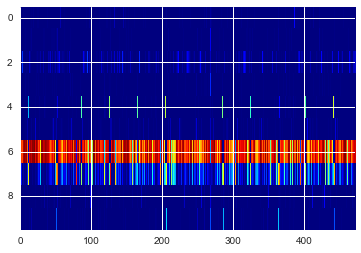

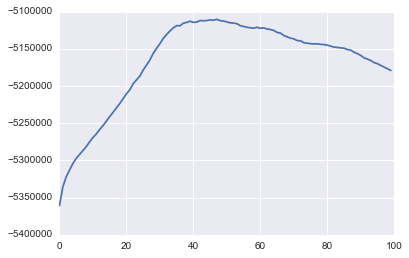

In [4]:
#################### STANDARD GIBBS SAMPLING #################################

# Randomly assign a topic to each word in each document (qil)
qs = randomly_assign_topics( docs_i, K )

# Number of times word v is assigned to topic k in document i
civk = np.zeros((D,V,K),dtype='int64')

# For each document
for i in xrange(D):
    
    # For each word in that document
    for j in xrange(L[i]):
        
        # The index of the document is i
        # The index of the word in docs_i[i] is j
        # The word id is docs_i[i][j]
        # Then the topic assigned is qs[i][j]
        # So we want civk[i,qs[i][j],docs_i[i][j]]
        
        civk[i,docs_i[i][j],qs[i][j]] += 1
        
# Create cvk, cik

# cvk is V by K
cvk = np.sum(civk, axis=0)

# cik is D by K
cik = np.sum(civk, axis=1)

alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

# topic distributions (shape K,V), aka bk in diagram
# For each topic (column), you draw one V-dimensional sample from Dirichlet
topics = np.zeros((K,V))

# per-document-topic distributions (shape D,K) aka pi_i in diagram
# For each document, you draw a sample
pdtm = np.zeros((D,K))

for i in xrange(D):
    # Get a Dirichlet sample w/ alphas + cik for doc, store in Dth row
    pdtm[i,:] = np.random.dirichlet(alphas + cik[i,:])

for k in xrange(K):
    # Get a Dirichlet sample w/ gammas + cvk for topic, store in Kth row
    topics[k,:] = np.random.dirichlet(gammas + cvk[:,k])   

max_iters = 100
likelihoods = np.zeros(max_iters)
for iters in range(0,max_iters):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    likelihoods[iters] = p
    print "Iter %d, p=%.2f" % (iters,p)
 
    # Resample per-word topic assignments qs
    
    # For each document
    for i in xrange(D):
        # For each word in that document
        for l in xrange(L[i]):
            p_il = np.zeros(K)
            
            # Subtract one from the relevant entries in civk, cvk, cik
            civk[i,docs_i[i][l],qs[i][l]] -= 1
            cvk[docs_i[i][l],qs[i][l]] -= 1
            cik[i,qs[i][l]] -= 1
            
            # Get the updated distribution for that word (array of length K)
            for k in xrange(K):
                p_il[k] = pdtm[i,k]*topics[k,docs_i[i][l]]
                
            # Normalize it
            p_il = p_il/np.sum(p_il)
            
            # Sample from it to update qs[i][l]
            qs[i][l] = np.random.choice(K, size=1, p=p_il)[0]
            
            # Update civk, cvk, cik
            civk[i,docs_i[i][l],qs[i][l]] += 1
            cvk[docs_i[i][l],qs[i][l]] += 1
            cik[i,qs[i][l]] += 1
            
 
    # resample per-document topic mixtures pdtm
    for i in xrange(D):
        # Get a Dirichlet sample w/ alphas + cik for doc, store in Dth row
        pdtm[i,:] = np.random.dirichlet(alphas + cik[i,:])
 
    # resample topics
    for k in xrange(K):
        # Get a Dirichlet sample w/ gammas + cvk for topic, store in Kth row
        topics[k,:] = np.random.dirichlet(gammas + cvk[:,k])   
        
    
plt.imshow(pdtm.T, interpolation='nearest', cmap='jet', aspect='auto')
plt.show()
    
plt.plot(likelihoods)
plt.show()

In [17]:
for j in xrange(10):
    print "15 Most Popular Words for Topic ", j
    vals = np.argsort(topics[j,:])[-15:]
    words = []
    for i in xrange(15):
        words.append(vindhash[vals[i]])
    print words, '\n'

15 Most Popular Words for Topic  0
['sorrels', 'moriah', 'rock', 'silver', 'firepower', 'context', 'overarching', 'academicians', 'chasm', 'ida', 'matthias', 'paid', 'armenia', 'bag', 'tithing'] 

15 Most Popular Words for Topic  1
['waits', 'landings', 'eased', 'rolled', 'matsumori', 'discussed', 'interests', 'article', 'sings', 'abilities', 'exciting', 'nuggets', 'medical', 'wholesome', 'wholeheartedly'] 

15 Most Popular Words for Topic  2
['aunt', 'temple', 'virtue', 'eva', 'mothers', 'mother', 'courage', 'school', 'young', 'marriage', 'she', 'women', 'your', 'you', 'her'] 

15 Most Popular Words for Topic  3
['incentive', 'swans', 'crayons', 'promotes', 'unthinkable', 'globe', 'ritual', 'sophia', 'amar', 'effectively', 'clippers', 'twig', 'baggage', 'oath', 'keystone'] 

15 Most Popular Words for Topic  4
['first', 'g', 'seventy', 'presidency', 'r', 'm', 'counselor', 'l', 'opposed', 'sustain', 'favor', 'proposed', 'it', 'please', 'manifest'] 

15 Most Popular Words for Topic  5
['

# Collapsed Gibbs Sampling

In [18]:
######################## SETUP CODE ########################################

vocab = set()
docs = []
 
D = 472 # number of documents
#D = 25
K = 10 # number of topics
 
# open each file, convert everything to lowercase and strip non-letter symbols,
# split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files\output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
        
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1

# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids
docs_i = []
for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )
    
L = np.array([len(docs_i[i]) for i in xrange(D)])

In [19]:
##################### HELPER FUNCTIONS ######################################

def randomly_assign_topics(docs_i, K):
    
    # qs[i][j] is the topic assigned to the jth word in the ith doc
    return [np.random.randint(0,K-1,L[i]) for i in xrange(len(docs_i))]

def compute_data_likelihood(docs_i, qs, topics, pdtm):
    likelihood = 0
    
    # For every document
    for i in xrange(D):
        # For every word in the document
        for l in xrange(L[i]):
            # Get the topic associated w/ the word from qs[i][l]
            # Get the ID of the word docs_i[i][l]
            # Access the sample from topics associate with that topic and word ID
            # Add to the likelihood the log of that sample
            likelihood += np.log(topics[qs[i][l],docs_i[i][l]])
            
    return likelihood

In [ ]:
#################### COLLAPSED GIBBS SAMPLING #################################
D = 472

# Randomly assign a topic to each word in each document (qil)
qs = randomly_assign_topics( docs_i, K )

# Number of times word v is assigned to topic k in document i
civk = np.zeros((D,V,K),dtype='int64')

# For each document
for i in xrange(D):
    
    # For each word in that document
    for j in xrange(L[i]):
        
        # The index of the document is i
        # The index of the word in docs_i[i] is j
        # The word id is docs_i[i][j]
        # Then the topic assigned is qs[i][j]
        # So we want civk[i,qs[i][j],docs_i[i][j]]
        
        civk[i,docs_i[i][j],qs[i][j]] += 1
        
# Create cvk, cik

# cvk is V by K
cvk = np.sum(civk, axis=0)

# cik is D by K
cik = np.sum(civk, axis=1)

# ck is length K
ck = np.sum(cik, axis=0) # DIFFERENT

alphas = np.ones((K,1))[:,0]
gammas = np.ones((V,1))[:,0]

# topic distributions (shape K,V), aka bk in diagram
# For each topic (column), you draw one V-dimensional sample from Dirichlet
topics = np.zeros((K,V))

# per-document-topic distributions (shape D,K) aka pi_i in diagram
# For each document, you draw a sample
pdtm = np.zeros((D,K))

for i in xrange(D):
    # Get a Dirichlet sample w/ alphas + cik for doc, store in Dth row
    pdtm[i,:] = np.random.dirichlet(alphas + cik[i,:])

for k in xrange(K):
    # Get a Dirichlet sample w/ gammas + cvk for topic, store in Kth row
    topics[k,:] = np.random.dirichlet(gammas + cvk[:,k])   

max_iters = 100
likelihoods = np.zeros(max_iters)
for iters in range(0,max_iters):
    p = compute_data_likelihood( docs_i, qs, topics, pdtm )
    likelihoods[iters] = p
    print "Iter %d, p=%.2f" % (iters,p)
 
    # Resample per-word topic assignments qs
    
    # For each document
    for i in xrange(D):
        # For each word in that document
        for l in xrange(L[i]):
            v = docs_i[i][l]
            p_il = np.zeros(K)
            
            # Subtract one from the relevant entries in civk, cvk, cik
            #civk[i,v,qs[i][l]] -= 1
            old_k = qs[i][l]
            
            
            # Get the updated distribution for that word (array of length K)
            for k in xrange(K):
                #p_il[k] = pdtm[i,k]*topics[kyou,docs_i[i][l]]
                
                # DIFFERENT
                frac1 = (cvk[v,k]+1)/(ck[k]+V)
                frac2 = (cik[i,k]+1)/(L[i]+K)
                p_il[k] = frac1*frac2
                
            # Normalize it
            p_il = p_il/np.sum(p_il)
            
            # Sample from it to update qs[i][l]
            qs[i][l] = np.random.choice(K, size=1, p=p_il)[0]
            
            cvk[v,old_k] -= 1
            cik[i,old_k] -= 1
            ck[old_k] -= 1 # DIFFERENT
            
            # Update civk, cvk, cik
            #civk[i,v,qs[i][l]] += 1
            cvk[v,qs[i][l]] += 1
            cik[i,qs[i][l]] += 1
            ck[qs[i][l]] += 1 # DIFFERENT
            
 
    # resample per-document topic mixtures pdtm
    #for i in xrange(D):
        # Get a Dirichlet sample w/ alphas + cik for doc, store in Dth row
    #    pdtm[i,:] = np.random.dirichlet(alphas + cik[i,:])
 
    # resample topics
    for k in xrange(K):
        # Get a Dirichlet sample w/ gammas + cvk for topic, store in Kth row
        topics[k,:] = np.random.dirichlet(gammas + cvk[:,k])   
        
    
plt.imshow(pdtm.T, interpolation='nearest', cmap='jet', aspect='auto')
plt.show()
    
plt.plot(likelihoods)
plt.show()

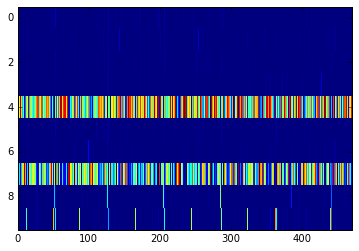

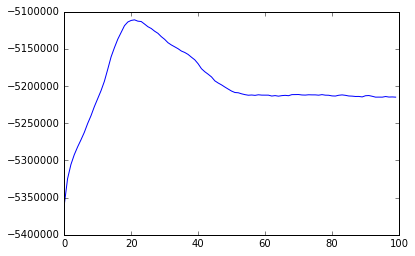

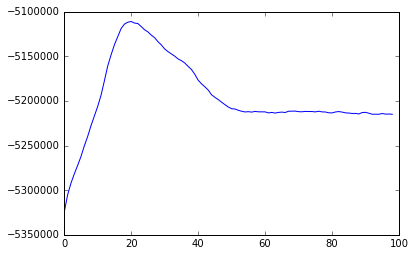

15 Most Popular Words for Topic  0
['expedient', 'lowing', 'shrank', 'inconsistent', 'cyberspace', 'evidences', 'puzzled', 'oil', 'privileged', 'persuasively', 'disuse', 'edwin', 'edgley', 'tribulations', 'rumors'] 

15 Most Popular Words for Topic  1
['missed', 'slothful', 'built', 'wandering', 'tallest', 'submissiveness', 'peninsula', 'ahasuerus', 'failing', 'answering', 'orchestra', 'envisioned', 'vicencio', 'mothers', 'beware'] 

15 Most Popular Words for Topic  2
['selfishly', 'wasting', 'difficulty', 'bolstered', 'distills', 'punishing', 'hemisphere', 'trunk', 'heidi', 'include', 'scientists', 'credentialed', 'rattlesnake', 'reside', 'pieced'] 

15 Most Popular Words for Topic  3
['whispering', 'denigrated', 'finland', 'iniquities', 'bar', 'commented', 'victories', 'dispel', 'recovery', 'purity', 'doubled', 'beholdest', 'handy', 'samaria', 'trout'] 

15 Most Popular Words for Topic  4
['with', 'he', 'as', 'is', 'for', 'we', 'that', 'you', 'i', 'a', 'in', 'of', 'and', 'to', 'the']

In [8]:
# Import results from other notebook
pdtm_collapsed = np.load('pdtm_collapsed.npy')
likelihoods_collapsed = np.load('likelihoods_collapsed.npy')
topics_collapsed = np.load('topics_collapsed.npy')

plt.imshow(pdtm_collapsed.T, interpolation='nearest', cmap='jet', aspect='auto')
plt.show()

plt.plot(likelihoods_collapsed)
plt.show()

plt.plot(likelihoods_collapsed[1:])
plt.show()

for j in xrange(10):
    print "15 Most Popular Words for Topic ", j
    vals = np.argsort(topics_collapsed[j,:])[-15:]
    words = []
    for i in xrange(15):
        words.append(vindhash[vals[i]])
    print words, '\n'